# **Libraries**

In [1]:
import numpy as np
import time
import math
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import SGD

# **Load Dataset**

In [2]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize images
y_train = y_train.flatten()
y_test = y_test.flatten()

# **Classes**

In [21]:
# Class labels for CIFAR-10
class_names = [
    'Airplane',    # 0
    'Automobile',  # 1
    'Bird',        # 2
    'Cat',         # 3
    'Deer',        # 4
    'Dog',         # 5
    'Frog',        # 6
    'Horse',       # 7
    'Ship',        # 8
    'Truck'        # 9
]

# **Build Model**

In [33]:
# Define the shallow neural network

def build_shallow_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),  # Use the Input layer explicitly
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(10, activation='softmax')  # Output layer for 10 classes
    ])
    return model

# Create the model instance
model = build_shallow_model()

# **Learning Rate Schedulers**

In [26]:
# Step decay learning rate schedule
def step_decay(epoch):
    initial_lr = 0.002
    drop = 0.5
    epoch_drop = 10
    return initial_lr * (drop ** (epoch // epoch_drop))

In [34]:
# Exponential decay learning rate schedule
def exponential_decay(epoch):
    initial_lr = 0.002
    k = 0.1
    return initial_lr * np.exp(-k * epoch)

# **Optimizers**

# **Stochastic Gradient Descent with Warm Restarts**

In [5]:
    # One-hot encode the labels
    y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [7]:
# SGDR learning rate schedule using cosine annealing
def sgdr_schedule(epoch, eta_max=0.01, eta_min=0.001, T_0=10):
    T_cur = epoch % T_0  # Number of epochs since last restart
    return eta_min + 0.5 * (eta_max - eta_min) * (1 + math.cos(math.pi * T_cur / T_0))


model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Create LearningRateScheduler callback for SGDR
lr_scheduler = LearningRateScheduler(sgdr_schedule)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with SGDR learning rate scheduler
start_time = time.time()
history_sgdr = model.fit(x_train, y_train_one_hot, epochs=50, validation_data=(x_test, y_test_one_hot), callbacks=[lr_scheduler, early_stopping])
training_time_sgdr = time.time() - start_time

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test_one_hot, verbose=0)

# Record the accuracy, test accuracy, and training time
print(f"Training Time: {training_time_sgdr:.2f}s")
print(f"Final Validation Accuracy: {history_sgdr.history['val_accuracy'][-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.3906 - loss: 1.7231 - val_accuracy: 0.4041 - val_loss: 1.6776 - learning_rate: 0.0100
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.4297 - loss: 1.6265 - val_accuracy: 0.4269 - val_loss: 1.6175 - learning_rate: 0.0098
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.4440 - loss: 1.5853 - val_accuracy: 0.4509 - val_loss: 1.5659 - learning_rate: 0.0089
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4623 - loss: 1.5307 - val_accuracy: 0.4548 - val_loss: 1.5338 - learning_rate: 0.0073
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.4835 - loss: 1.4856 - val_accuracy: 0.4608 - val_loss: 1.5173 - learning_rate: 0.0051
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.4901 - loss: 1.4652 - val_accuracy: 0.4749 - val_loss: 1.4977 - learning_rate: 0.0031
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.

**Stochastic Gradient Descent Confusion matrix**

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


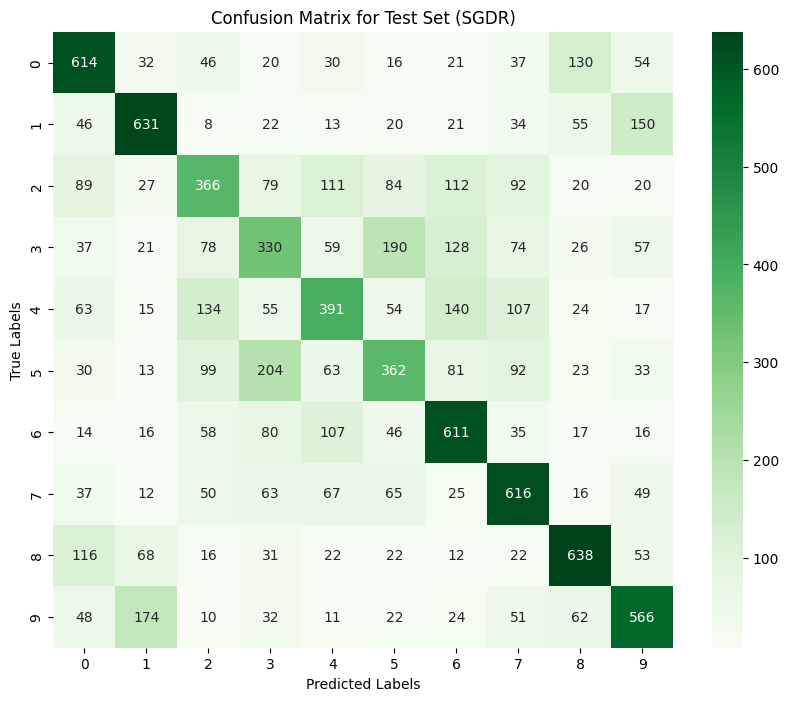

In [8]:
# Plot Accuracy and Loss
def plot_accuracy_loss(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Predict for the test set and compute confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Compute confusion matrix
confusion_matrix_test = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Greens', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix for Test Set (SGDR)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


**Accuracy and Loss curves**

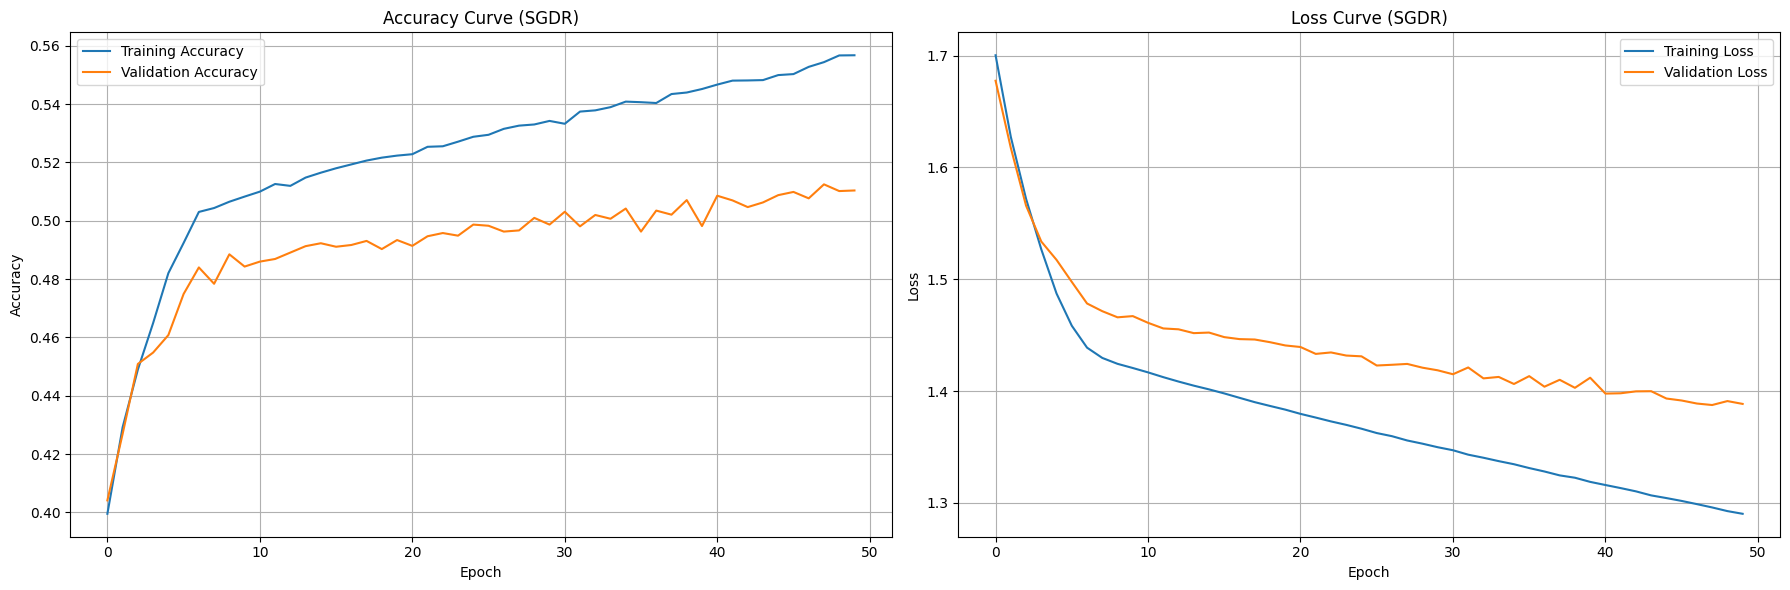

In [13]:
# Extract training and validation accuracy/loss from the history object
training_accuracy = history_sgdr.history['accuracy']
validation_accuracy = history_sgdr.history['val_accuracy']
training_loss = history_sgdr.history['loss']
validation_loss = history_sgdr.history['val_loss']

# Create a figure with subplots
plt.figure(figsize=(18, 6))

# Plot accuracy curves
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curve (SGDR)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss Curve (SGDR)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

**Class-wise accuracy**

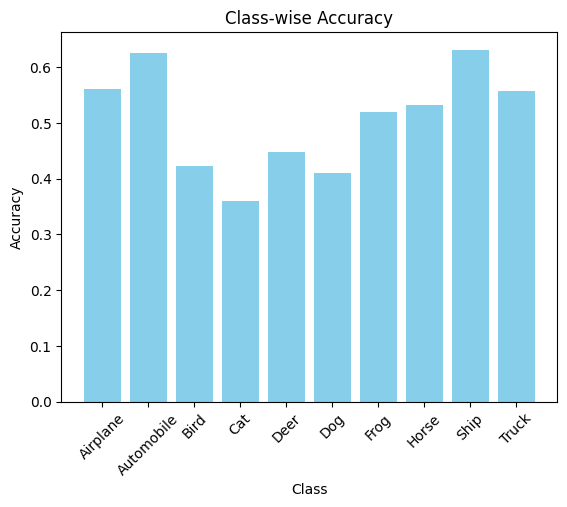

In [16]:
from sklearn.metrics import classification_report

y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted labels
class_report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
class_accuracy = [class_report[cls]['precision'] for cls in class_names]

plt.bar(class_names, class_accuracy, color='skyblue')
plt.title('Class-wise Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()


**Learning rate restart curve**

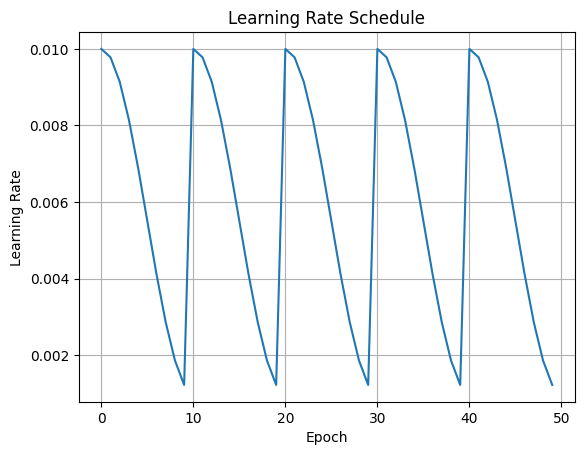

In [18]:
lr_values = [sgdr_schedule(epoch) for epoch in range(50)]  # Assuming 50 epochs
plt.plot(range(50), lr_values)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

**Miscalssified examples**

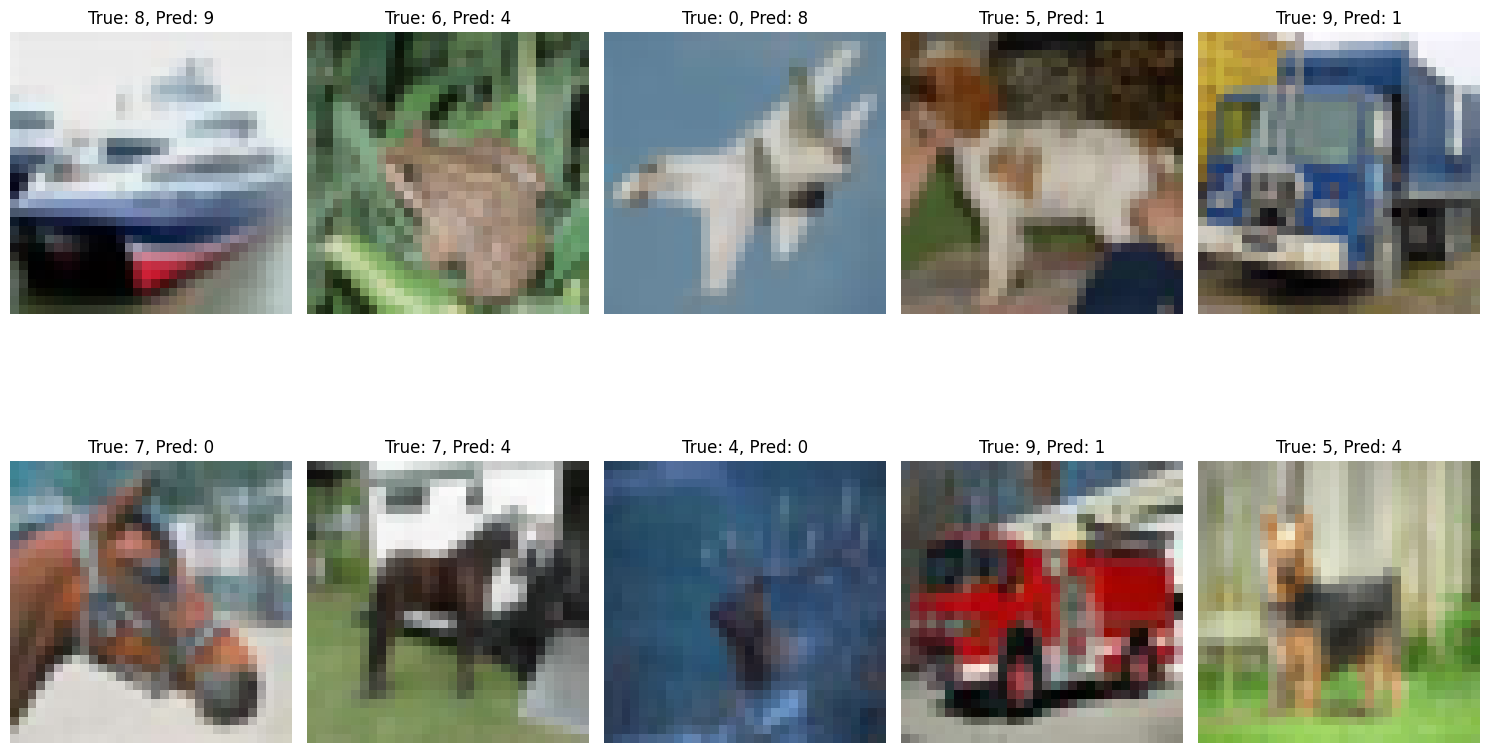

In [20]:
misclassified_indices = np.where(y_true != y_pred_classes)[0]

plt.figure(figsize=(15, 10))
for i, index in enumerate(misclassified_indices[:10]):  # Show the first 10 misclassified examples
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[index])  # Adjust as per your data preprocessing
    plt.title(f"True: {y_true[index]}, Pred: {y_pred_classes[index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Nesterov Accelerated Gradient**

In [41]:
# NAG optimizer with momentum
nag_optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

**NAG with step decay**

In [26]:
# Compile the model with NAG optimizer
model.compile(optimizer=nag_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler for step decay
lr_scheduler_step = LearningRateScheduler(step_decay)

# Record the start time for training
start_time = time.time()

# Train the model with step decay and validate
history_step_decay = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[lr_scheduler_step])

# Calculate the total training time
training_time = time.time() - start_time

# Print the final validation accuracy and training time
final_validation_accuracy = history_step_decay.history['val_accuracy'][-1]  # Get the final validation accuracy
print(f"Training Time: {training_time:.2f} seconds")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)  # Test set evaluation
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.3038 - loss: 1.9203 - val_accuracy: 0.3911 - val_loss: 1.7104 - learning_rate: 0.0100
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.3958 - loss: 1.6955 - val_accuracy: 0.3987 - val_loss: 1.6606 - learning_rate: 0.0100
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.4238 - loss: 1.6167 - val_accuracy: 0.3962 - val_loss: 1.6550 - learning_rate: 0.0100
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.4343 - loss: 1.5922 - val_accuracy: 0.4255 - val_loss: 1.6203 - learning_rate: 0.0100
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.4396 - loss: 1.5723 - val_accuracy: 0.4361 - val_loss: 1.5947 - learning_rate: 0.0100
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.4541 - loss: 1.5401 - val_accuracy: 0.4448 - val_loss: 1.5650 - learning_rate: 0.0100
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accura

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


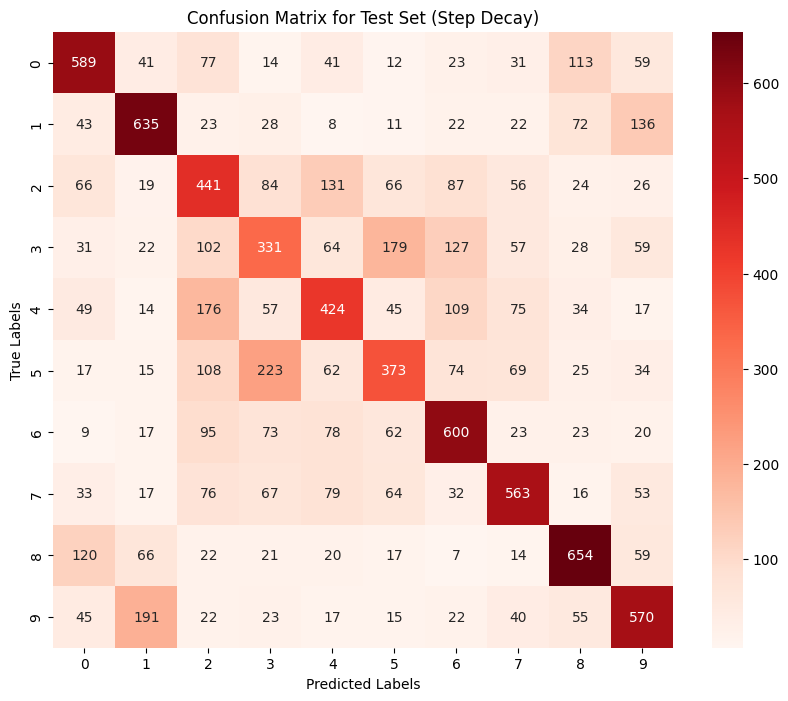

In [27]:
# Predict on the test set for confusion matrix
y_pred_test = model.predict(x_test)  # Predictions for the test set
y_pred_classes_test = np.argmax(y_pred_test, axis=1)  # Predicted class labels
y_true_test = y_test.flatten()  # True class labels from the test set

# Compute confusion matrix for testing
cm_test = confusion_matrix(y_true_test, y_pred_classes_test)

# Plot confusion matrix for testing
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix for Test Set (Step Decay)")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


**Accuracy and Loss curves**

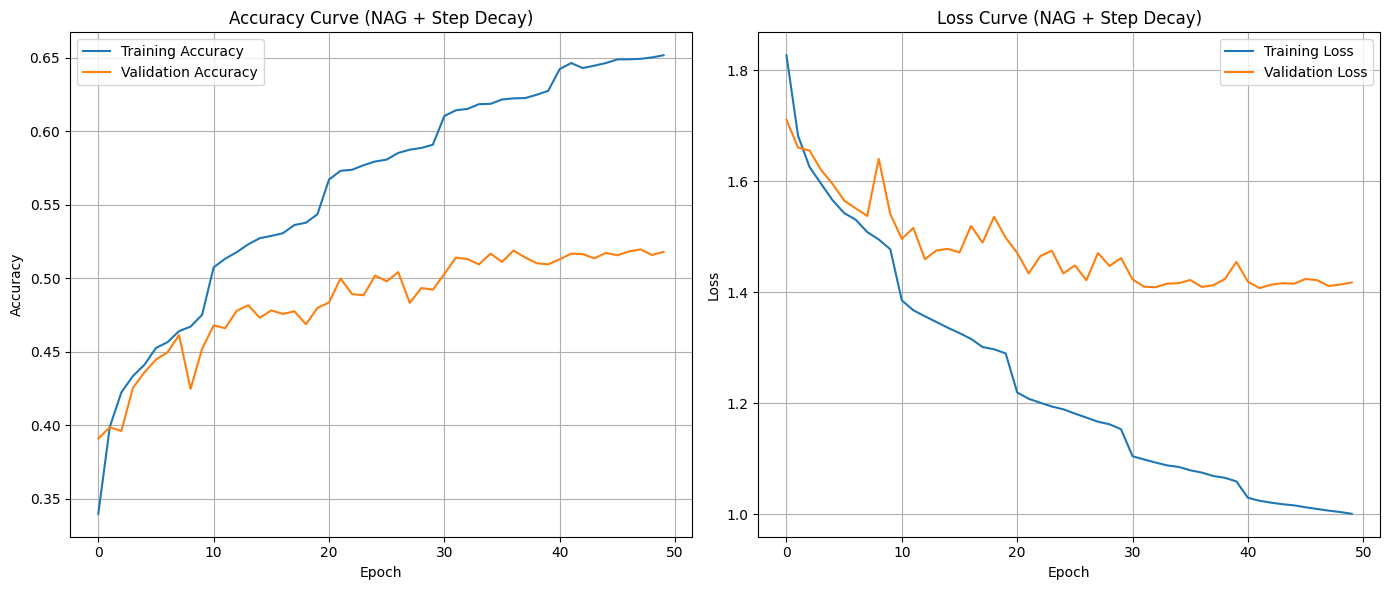

In [28]:
# Extract training and validation metrics from history
training_accuracy = history_step_decay.history['accuracy']
validation_accuracy = history_step_decay.history['val_accuracy']
training_loss = history_step_decay.history['loss']
validation_loss = history_step_decay.history['val_loss']

# Plot training and validation accuracy/loss side by side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy plot
ax[0].plot(training_accuracy, label='Training Accuracy')
ax[0].plot(validation_accuracy, label='Validation Accuracy')
ax[0].set_title('Accuracy Curve (NAG + Step Decay)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss plot
ax[1].plot(training_loss, label='Training Loss')
ax[1].plot(validation_loss, label='Validation Loss')
ax[1].set_title('Loss Curve (NAG + Step Decay)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

**Learning Rate Schedule**

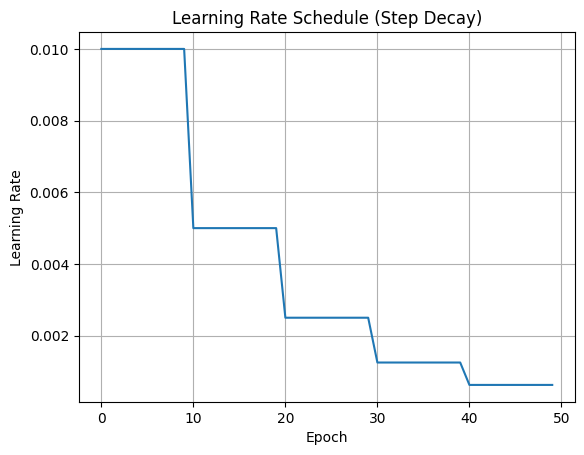

In [30]:
# Visualize the learning rate schedule
lr_values = [step_decay(epoch) for epoch in range(50)]  # Adjust for 50 epochs
plt.plot(range(50), lr_values)
plt.title('Learning Rate Schedule (Step Decay)')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

**Class-wise Accuracy**

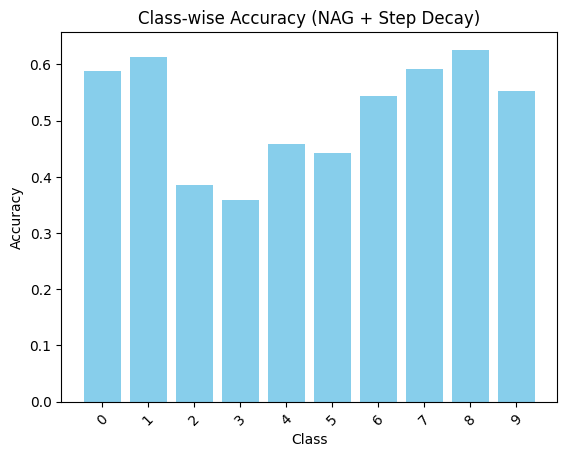

In [32]:
from sklearn.metrics import classification_report

# Generate a classification report
class_names = [str(i) for i in range(10)]  # Assuming 10 classes
class_report = classification_report(y_test, y_pred_classes_test, target_names=class_names, output_dict=True)

# Extract class-wise accuracy (precision as a proxy for accuracy)
class_accuracy = [class_report[cls]['precision'] for cls in class_names]

# Plot class-wise accuracy
plt.bar(class_names, class_accuracy, color='skyblue')
plt.title('Class-wise Accuracy (NAG + Step Decay)')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

**NAG with exp. decay**

In [42]:
# Compile the model with NAG optimizer
model.compile(optimizer=nag_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler for exponential decay
lr_scheduler_exp = LearningRateScheduler(exponential_decay)

# Record the start time for training
start_time = time.time()

# Train the model with exponential decay and validate
history_exp_decay = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[lr_scheduler_exp])

# Calculate the total training time
training_time = time.time() - start_time

# Print the final accuracy and training time
final_accuracy = history_exp_decay.history['val_accuracy'][-1]  # Get the final validation accuracy
print(f"Training Time: {training_time:.2f} seconds")
print(f"Final Validation Accuracy: {final_accuracy * 100:.2f}%")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)  # Test set evaluation
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.3044 - loss: 1.9174 - val_accuracy: 0.4030 - val_loss: 1.6852 - learning_rate: 0.0100
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.3916 - loss: 1.7002 - val_accuracy: 0.4035 - val_loss: 1.6483 - learning_rate: 0.0095
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.4199 - loss: 1.6298 - val_accuracy: 0.4122 - val_loss: 1.6467 - learning_rate: 0.0090
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.4306 - loss: 1.5863 - val_accuracy: 0.4019 - val_loss: 1.6648 - learning_rate: 0.0086
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.4454 - loss: 1.5541 - val_accuracy: 0.4321 - val_loss: 1.5880 - learning_rate: 0.0082
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.4558 - loss: 1.5263 - val_accuracy: 0.4352 - val_loss: 1.6176 - learning_rate: 0.0078
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accura

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


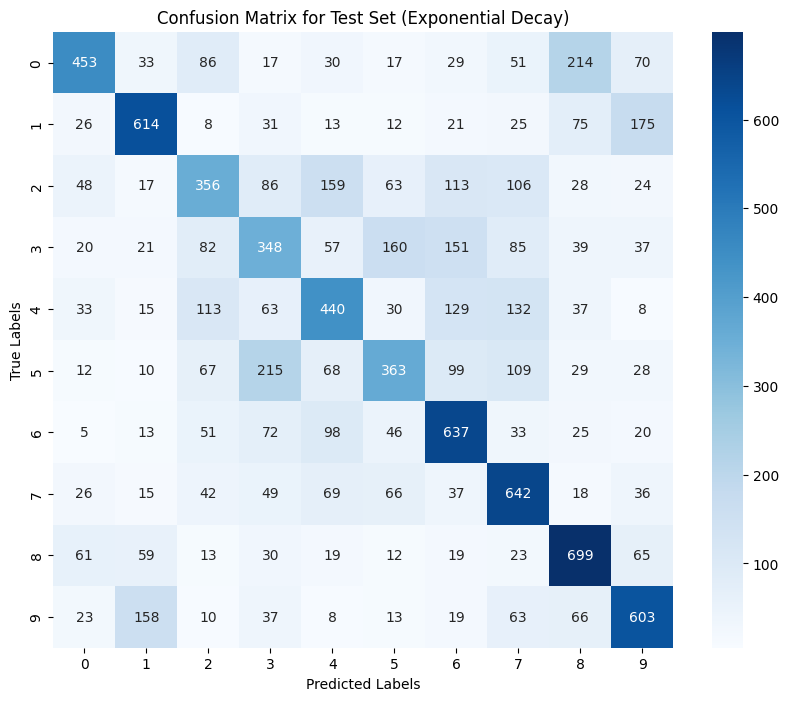

In [43]:
# Predict on the test set for confusion matrix
y_pred_test = model.predict(x_test)  # Predictions for the test set
y_pred_classes_test = np.argmax(y_pred_test, axis=1)  # Predicted class labels
y_true_test = y_test.flatten()  # True class labels from the test set

# Compute confusion matrix for testing
cm_test = confusion_matrix(y_true_test, y_pred_classes_test)

# Plot confusion matrix for testing
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix for Test Set (Exponential Decay)")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Training and Validation Accuracy/Loss Curves**

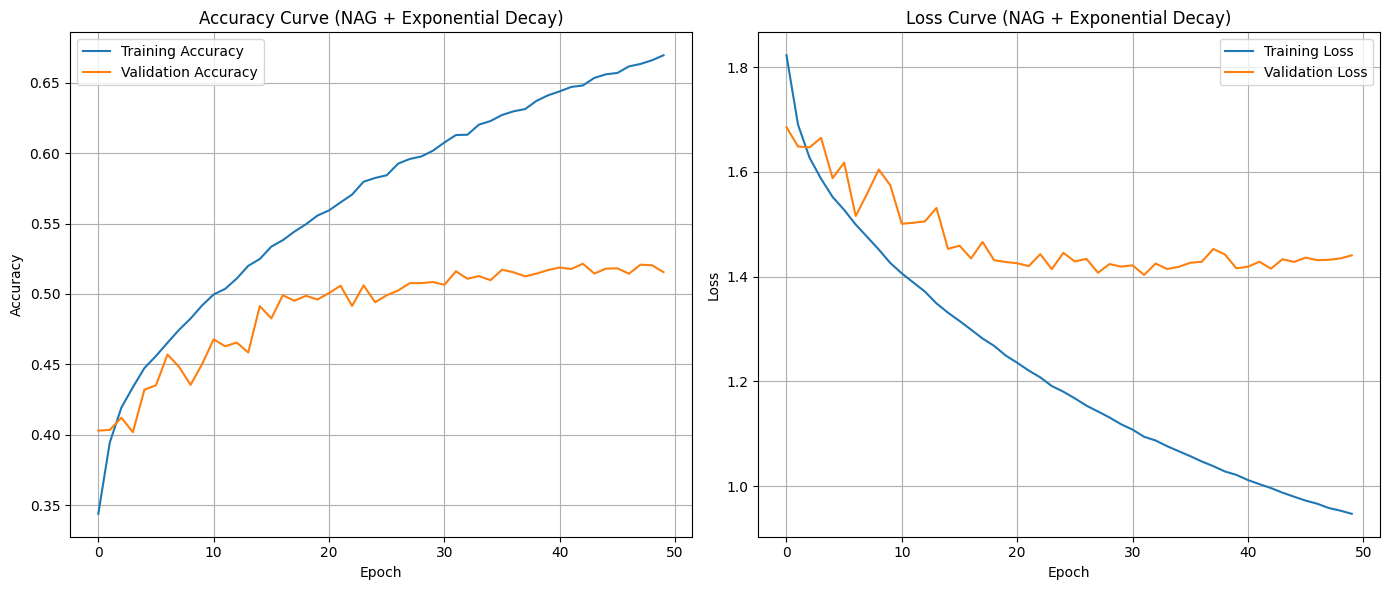

In [44]:
# Extract training and validation metrics from history
training_accuracy = history_exp_decay.history['accuracy']
validation_accuracy = history_exp_decay.history['val_accuracy']
training_loss = history_exp_decay.history['loss']
validation_loss = history_exp_decay.history['val_loss']

# Plot training and validation accuracy/loss side by side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy plot
ax[0].plot(training_accuracy, label='Training Accuracy')
ax[0].plot(validation_accuracy, label='Validation Accuracy')
ax[0].set_title('Accuracy Curve (NAG + Exponential Decay)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss plot
ax[1].plot(training_loss, label='Training Loss')
ax[1].plot(validation_loss, label='Validation Loss')
ax[1].set_title('Loss Curve (NAG + Exponential Decay)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


**Learning Rate Schedule**

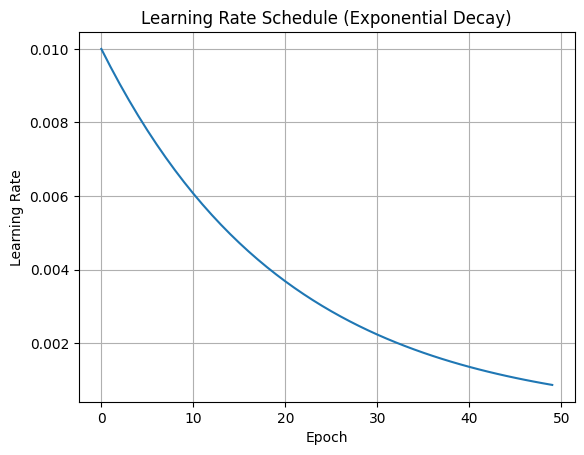

In [46]:
# Visualize the learning rate schedule
lr_values = [exponential_decay(epoch) for epoch in range(50)]  # Adjust for 50 epochs
plt.plot(range(50), lr_values)
plt.title('Learning Rate Schedule (Exponential Decay)')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

**Class-wise Accuracy**

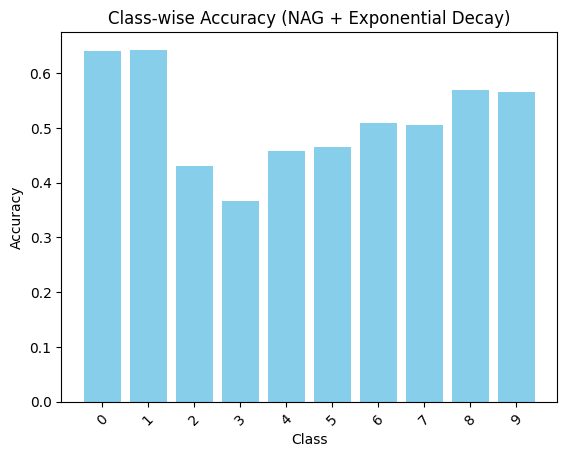

In [48]:
from sklearn.metrics import classification_report

# Generate a classification report
class_names = [str(i) for i in range(10)]  # Assuming 10 classes
class_report = classification_report(y_test, y_pred_classes_test, target_names=class_names, output_dict=True)

# Extract class-wise accuracy (precision as a proxy for accuracy)
class_accuracy = [class_report[cls]['precision'] for cls in class_names]

# Plot class-wise accuracy
plt.bar(class_names, class_accuracy, color='skyblue')
plt.title('Class-wise Accuracy (NAG + Exponential Decay)')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# **RMSProp**

**RMSPro with exp. decay**

In [52]:
# Define RMSProp optimizer
rmsprop_optimizer = RMSprop(learning_rate=0.0005, rho=0.85)

# Compile the model with RMSProp optimizer
model.compile(optimizer=rmsprop_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler for exponential decay
lr_scheduler_exp = LearningRateScheduler(exponential_decay)

# Start training and record time
start_time = time.time()

# Train the model with exponential decay and validate
history_exp_decay = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[lr_scheduler_exp])

# Calculate training time
training_time_rms_exp = time.time() - start_time

# Print the final validation accuracy and training time
final_val_accuracy_rms_exp = history_exp_decay.history['val_accuracy'][-1]
print(f"Training Time for RMSProp + Exponential Decay: {training_time_rms_exp:.2f} seconds")
print(f"Final Validation Accuracy for RMSProp + Exponential Decay: {final_val_accuracy_rms_exp * 100:.2f}%")

# Evaluate the model on the testing set
test_loss_rms_exp, test_accuracy_rms_exp = model.evaluate(x_test, y_test, verbose=0)

# Print the test accuracy
print(f"Test Accuracy for RMSProp + Exponential Decay: {test_accuracy_rms_exp * 100:.2f}%")


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.2486 - loss: 2.1828 - val_accuracy: 0.3387 - val_loss: 1.8692 - learning_rate: 0.0010
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.3621 - loss: 1.7921 - val_accuracy: 0.3178 - val_loss: 1.9028 - learning_rate: 9.5123e-04
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3923 - loss: 1.7325 - val_accuracy: 0.4045 - val_loss: 1.6805 - learning_rate: 9.0484e-04
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.4058 - loss: 1.6931 - val_accuracy: 0.4074 - val_loss: 1.7592 - learning_rate: 8.6071e-04
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - accuracy: 0.4167 - loss: 1.6767 - val_accuracy: 0.3873 - val_loss: 1.7652 - learning_rate: 8.1873e-04
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.4241 - loss: 1.6600 - val_accuracy: 0.4069 - val_loss: 1.7455 - learning_rate: 7.7880e-04
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22

Test Accuracy for RMSProp with Exponential Decay: 48.58%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


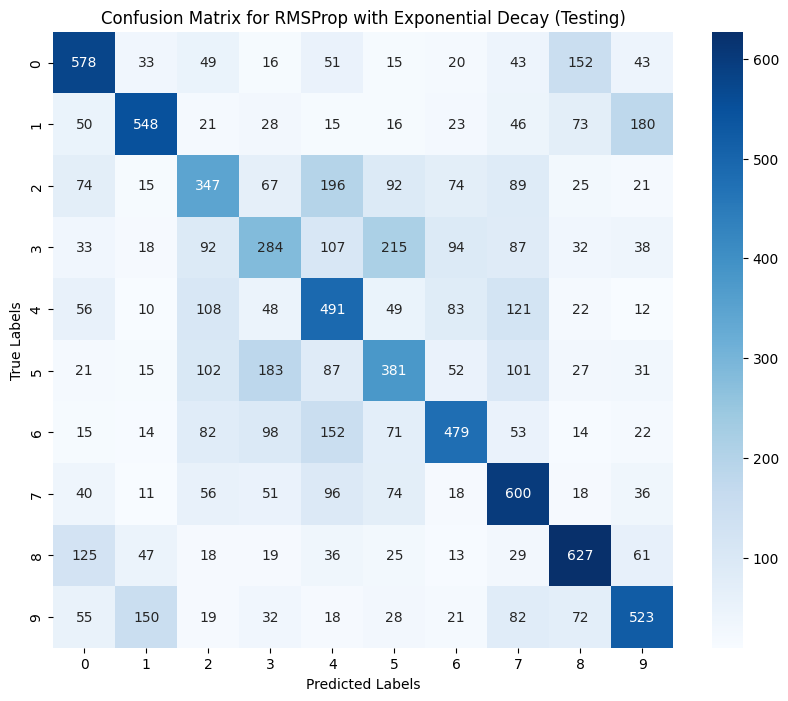

In [53]:
# Evaluate the model on the testing data
test_loss_rms_exp, test_accuracy_rms_exp = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy for RMSProp with Exponential Decay: {test_accuracy_rms_exp * 100:.2f}%")

# Predict on the testing data
y_pred_rms_exp_test = model.predict(x_test)
y_pred_classes_rms_exp_test = np.argmax(y_pred_rms_exp_test, axis=1)
y_true_rms_exp_test = y_test.flatten()  # Flatten the true labels for comparison if needed

# Compute confusion matrix for RMSProp + Exponential Decay (Testing)
cm_rms_exp_test = confusion_matrix(y_true_rms_exp_test, y_pred_classes_rms_exp_test)

# Plot confusion matrix for RMSProp + Exponential Decay (Testing)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rms_exp_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix for RMSProp with Exponential Decay (Testing)")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Accuracy and Loss Curves (Training and Validation)**

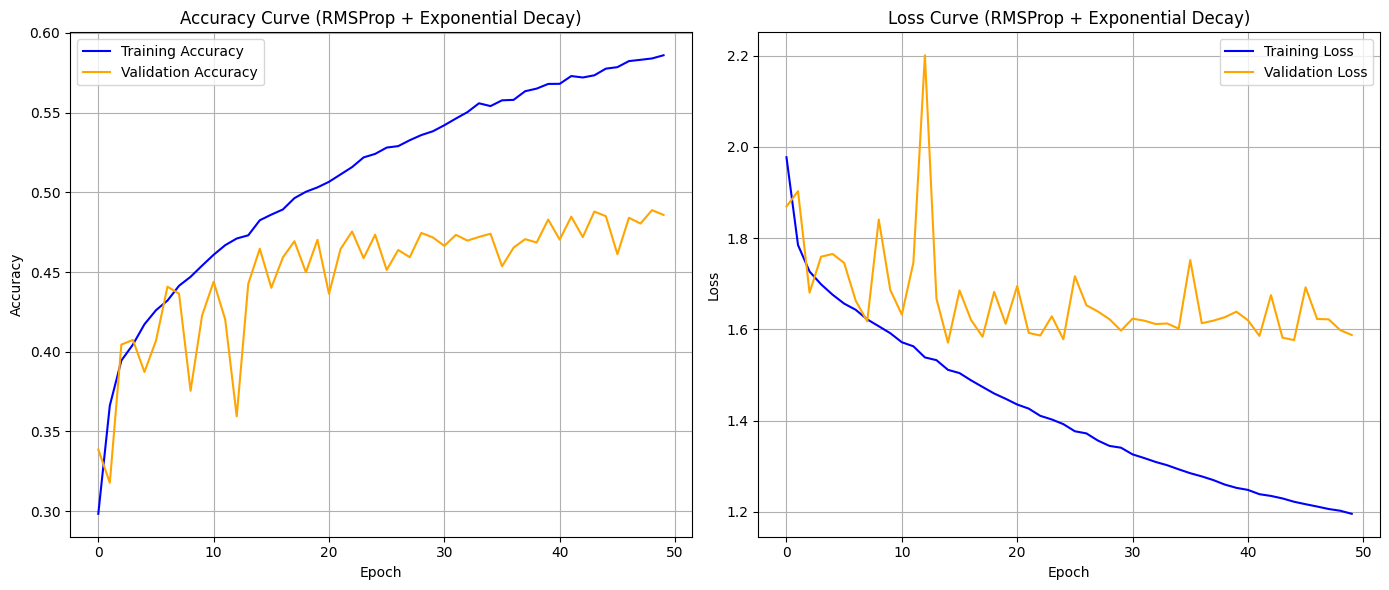

In [54]:
# Accuracy and Loss curves side by side
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_exp_decay.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_exp_decay.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy Curve (RMSProp + Exponential Decay)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_exp_decay.history['loss'], label='Training Loss', color='blue')
plt.plot(history_exp_decay.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Curve (RMSProp + Exponential Decay)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Learning Rate Schedule**

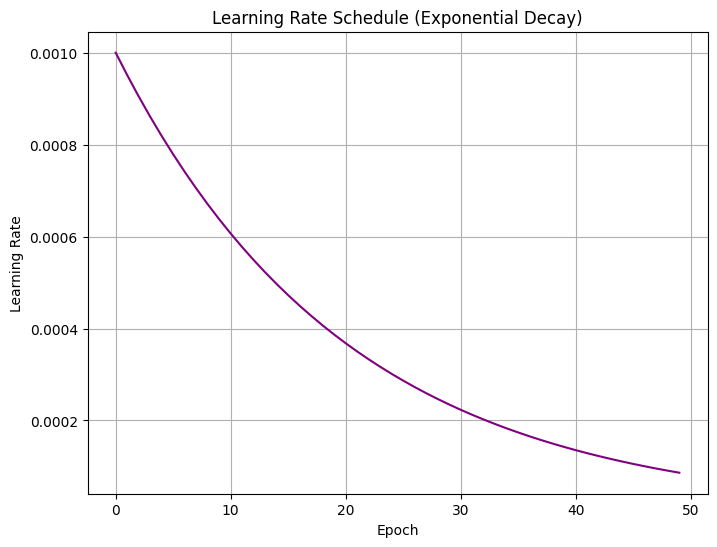

In [55]:
# Learning rate over epochs for exponential decay
epochs = np.arange(50)
learning_rates = [exponential_decay(epoch) for epoch in epochs]

plt.figure(figsize=(8, 6))
plt.plot(epochs, learning_rates, label='Learning Rate', color='purple')
plt.title('Learning Rate Schedule (Exponential Decay)')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()


**Class-wise Accuracy**

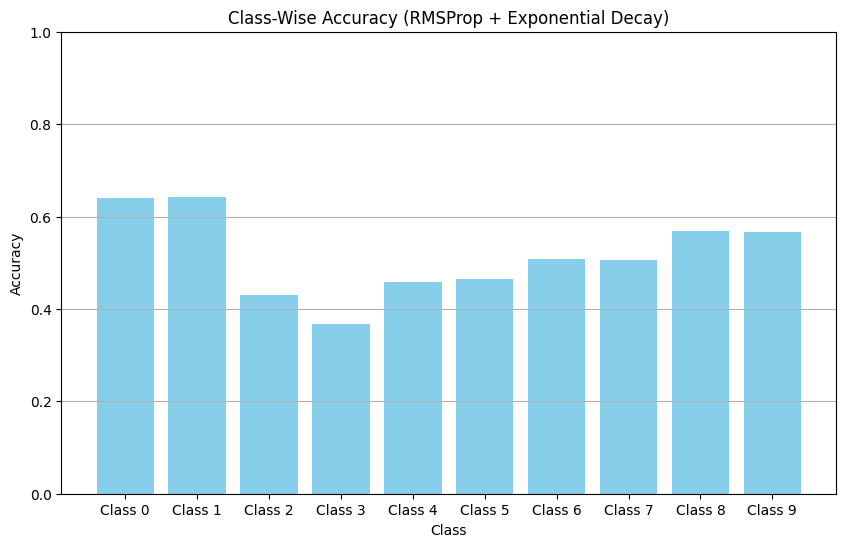

In [56]:
# Plot class-wise accuracy
plt.figure(figsize=(10, 6))
plt.bar(range(10), class_accuracy, color='skyblue')
plt.xticks(range(10), [f'Class {i}' for i in range(10)])
plt.ylim(0, 1)
plt.title('Class-Wise Accuracy (RMSProp + Exponential Decay)')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.show()

**RMSProp with step decay**

In [13]:
# Define RMSProp optimizer
rmsprop_optimizer = RMSprop(learning_rate=0.0005, rho=0.9)

# Compile the model with RMSProp optimizer
model.compile(optimizer=rmsprop_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler for step decay
lr_scheduler_step = LearningRateScheduler(step_decay)

# Start training and record time
start_time = time.time()

# Train the model with step decay and validate
history_step_decay = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[lr_scheduler_step])

# Calculate training time
training_time_rms_step = time.time() - start_time

# Print the final accuracy and training time for RMSProp + step Decay
final_accuracy_rms_step = history_step_decay.history['val_accuracy'][-1]
print(f"Training Time for RMSProp + step Decay: {training_time_rms_step:.2f} seconds")
print(f"Final Validation Accuracy for RMSProp + step Decay: {final_accuracy_rms_step * 100:.2f}%")

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.2617 - loss: 2.2256 - val_accuracy: 0.3220 - val_loss: 1.8818 - learning_rate: 0.0010
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.3770 - loss: 1.7523 - val_accuracy: 0.3914 - val_loss: 1.6868 - learning_rate: 0.0010
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.3987 - loss: 1.6917 - val_accuracy: 0.3763 - val_loss: 1.7424 - learning_rate: 0.0010
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.4145 - loss: 1.6535 - val_accuracy: 0.4045 - val_loss: 1.6660 - learning_rate: 0.0010
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.4240 - loss: 1.6334 - val_accuracy: 0.4004 - val_loss: 1.7315 - learning_rate: 0.0010
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.4253 - loss: 1.6150 - val_accuracy: 0.4265 - val_loss: 1.6247 - learning_rate: 0.0010
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accura

313/313 ━━━━━━━━━━━━━━━━━━━━ 114s 4ms/step


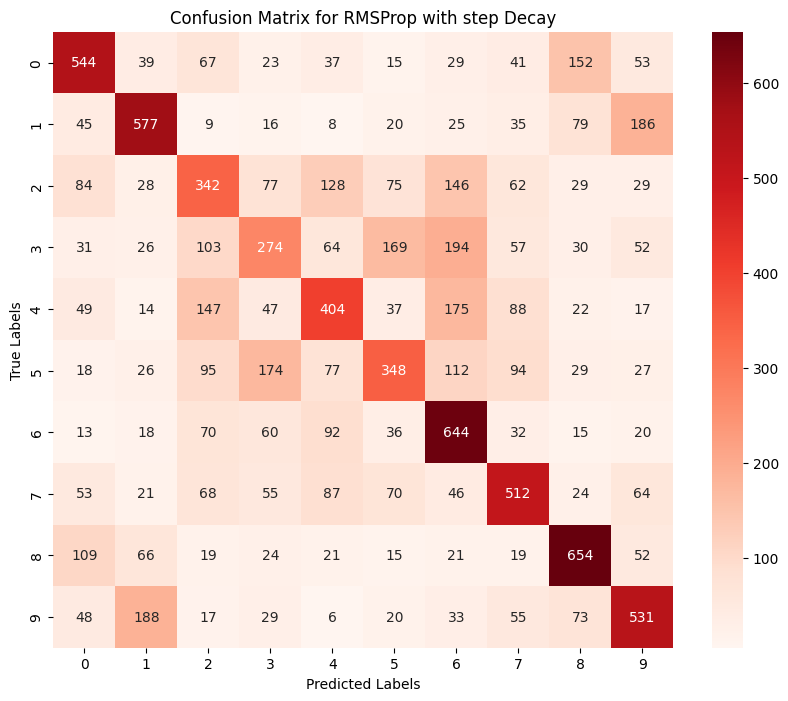

In [14]:
# Predict for confusion matrix
y_pred_rms_step = model.predict(x_test)
y_pred_classes_rms_step = np.argmax(y_pred_rms_step, axis=1)
y_true_rms_step = y_test.flatten()

# Compute confusion matrix for RMSProp + step Decay
cm_rms_step = confusion_matrix(y_true_rms_step, y_pred_classes_rms_step)

# Plot confusion matrix for RMSProp + step Decay
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rms_step, annot=True, fmt='d', cmap='Reds', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix for RMSProp with step Decay")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Training and Validation Accuracy Curves**

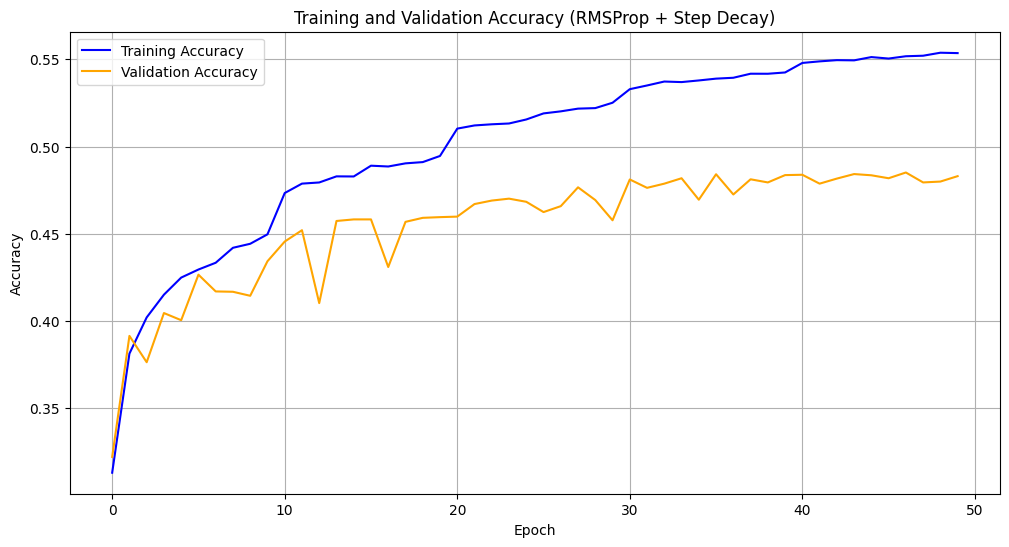

In [15]:
# Extract training and validation accuracy
training_accuracy = history_step_decay.history['accuracy']
validation_accuracy = history_step_decay.history['val_accuracy']

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(training_accuracy, label='Training Accuracy', color='blue')
plt.plot(validation_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy (RMSProp + Step Decay)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**Learning Rate Schedule Plot**

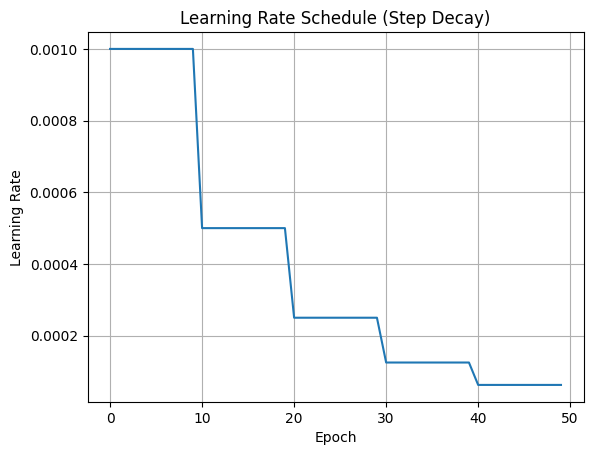

In [18]:
# Visualize the learning rate schedule
lr_values = [step_decay(epoch) for epoch in range(50)]  # Adjust for 50 epochs
plt.plot(range(50), lr_values)
plt.title('Learning Rate Schedule (Step Decay)')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

**Class-Wise Accuracy**

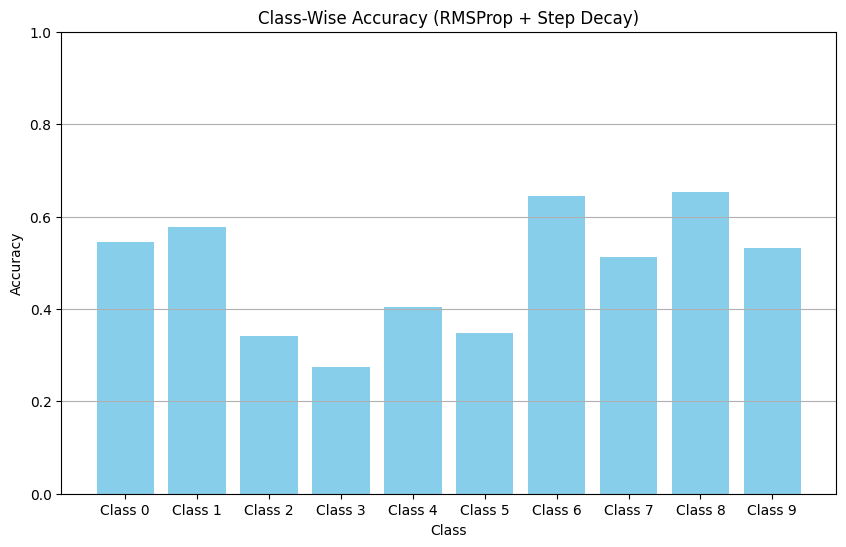

In [24]:
# Calculate class-wise accuracy (true positives / (true positives + false negatives))
class_accuracy = np.diagonal(cm_rms_step) / np.sum(cm_rms_step, axis=1)

# Plot class-wise accuracy
plt.figure(figsize=(10, 6))
plt.bar(range(10), class_accuracy, color='skyblue')
plt.xticks(range(10), [f'Class {i}' for i in range(10)])
plt.ylim(0, 1)
plt.title('Class-Wise Accuracy (RMSProp + Step Decay)')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.show()

# **NADAM**

**NADAM with step decay**

In [27]:
# Nadam optimizer with Step Decay
nadam_optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=nadam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler_step = LearningRateScheduler(step_decay)

# Record training time
start_time = time.time()

# Train the model
history_nadam_step = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[lr_scheduler_step])

training_time_step = time.time() - start_time

# Testing evaluation
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Training Time (Step Decay): {training_time_step:.2f} seconds")
print(f"Validation Accuracy (Step Decay): {history_nadam_step.history['val_accuracy'][-1] * 100:.2f}%")
print(f"Testing Accuracy (Step Decay): {test_accuracy * 100:.2f}%")


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.2994 - loss: 2.0399 - val_accuracy: 0.3896 - val_loss: 1.7219 - learning_rate: 0.0020
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.3874 - loss: 1.7193 - val_accuracy: 0.4000 - val_loss: 1.6941 - learning_rate: 0.0020
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.4064 - loss: 1.6641 - val_accuracy: 0.3964 - val_loss: 1.6672 - learning_rate: 0.0020
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.4172 - loss: 1.6287 - val_accuracy: 0.4094 - val_loss: 1.6406 - learning_rate: 0.0020
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.4250 - loss: 1.6087 - val_accuracy: 0.4255 - val_loss: 1.6055 - learning_rate: 0.0020
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.4331 - loss: 1.5879 - val_accuracy: 0.4291 - val_loss: 1.5954 - learning_rate: 0.0020
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accura

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


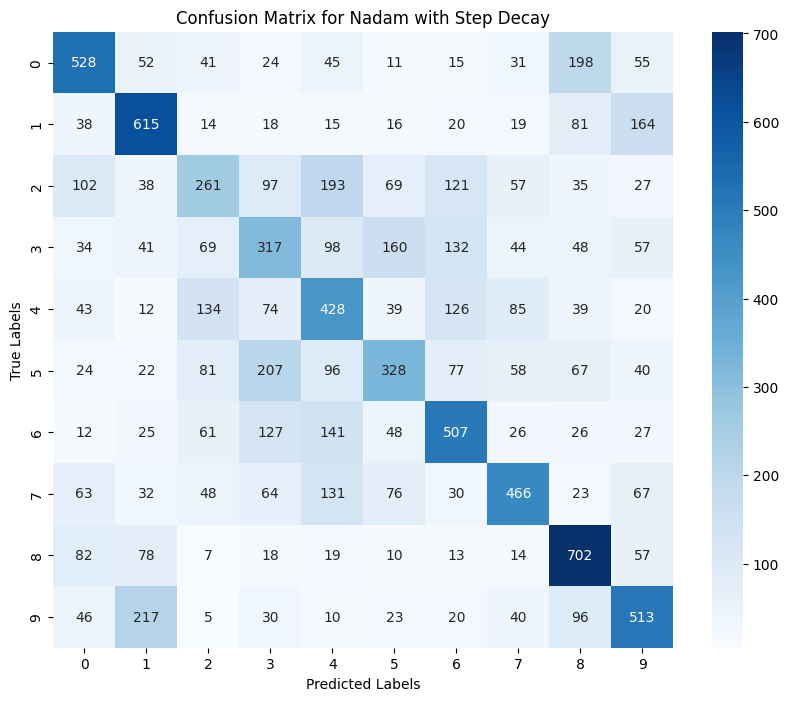

In [28]:
# Predict for confusion matrix
y_pred_step = model.predict(x_test)
y_pred_classes_step = np.argmax(y_pred_step, axis=1)
y_true_step = y_test.flatten()

# Compute confusion matrix
cm_step = confusion_matrix(y_true_step, y_pred_classes_step)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_step, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix for Nadam with Step Decay")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Training and Validation Accuracy/Loss Curves**

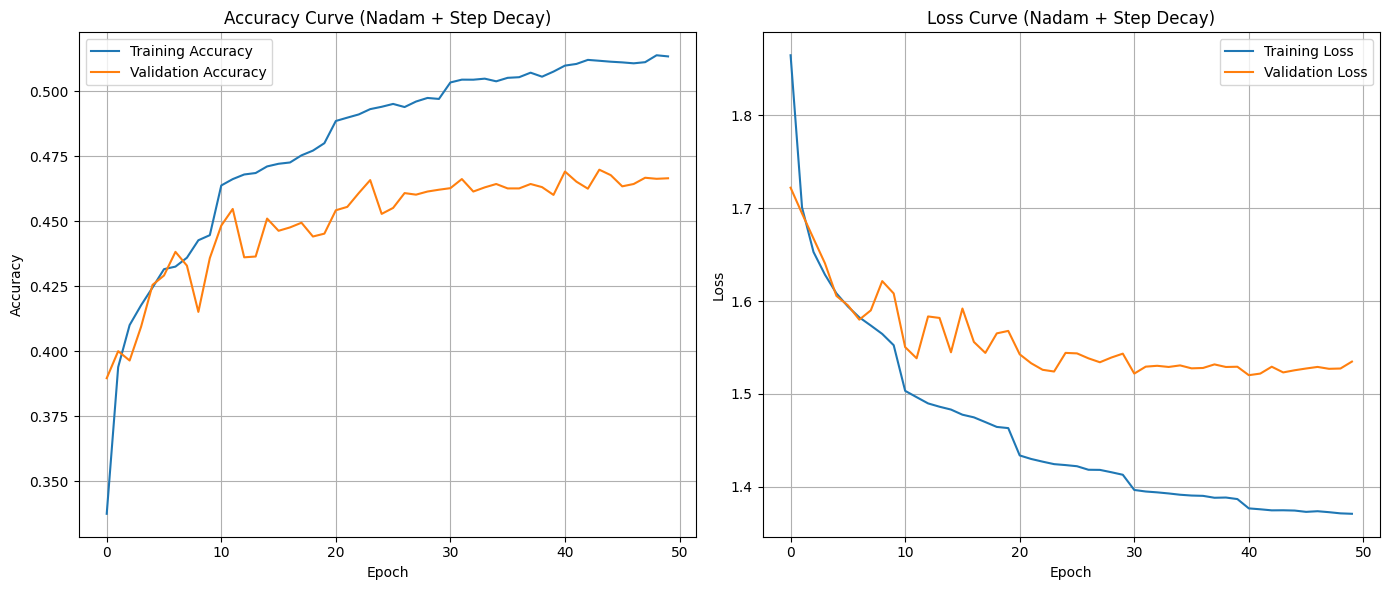

In [29]:
# Extract training and validation accuracy/loss from history
train_accuracy = history_nadam_step.history['accuracy']
val_accuracy = history_nadam_step.history['val_accuracy']
train_loss = history_nadam_step.history['loss']
val_loss = history_nadam_step.history['val_loss']

# Plot accuracy and loss curves
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy curve
ax[0].plot(train_accuracy, label='Training Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_title('Accuracy Curve (Nadam + Step Decay)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss curve
ax[1].plot(train_loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_title('Loss Curve (Nadam + Step Decay)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


**Learning Rate Schedule**

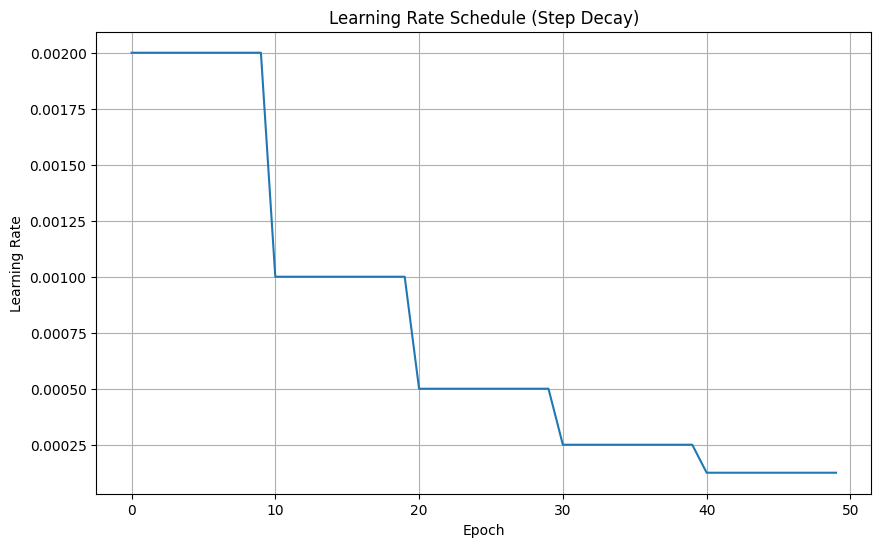

In [30]:
# Get learning rates at each epoch for the step decay
lr_schedule_values = [step_decay(epoch) for epoch in range(50)]

# Plot learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(range(50), lr_schedule_values, label='Learning Rate (Step Decay)')
plt.title('Learning Rate Schedule (Step Decay)')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()


**class-wise accuracy**

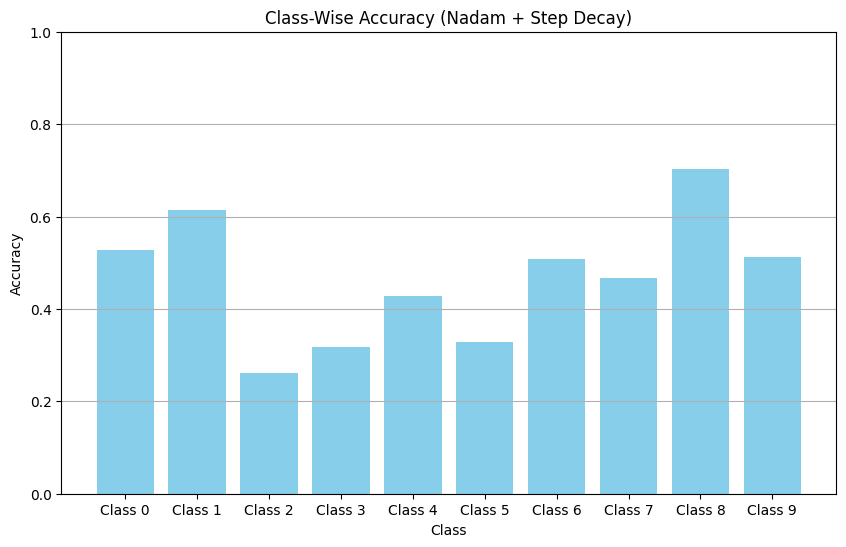

In [32]:
# Compute class-wise accuracy from confusion matrix
class_accuracy_nadam_step = np.diagonal(cm_step) / np.sum(cm_step, axis=1)

# Plot class-wise accuracy
plt.figure(figsize=(10, 6))
plt.bar(range(10), class_accuracy_nadam_step, color='skyblue')
plt.xticks(range(10), [f'Class {i}' for i in range(10)])
plt.ylim(0, 1)
plt.title('Class-Wise Accuracy (Nadam + Step Decay)')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.show()


**NADAM with exp. decay**

In [35]:
# Nadam optimizer with Exponential Decay
nadam_optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=nadam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler_exp = LearningRateScheduler(exponential_decay)

# Record training time
start_time = time.time()

# Train the model
history_nadam_exp = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[lr_scheduler_exp])

training_time_exp = time.time() - start_time

# Testing evaluation
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Training Time (Exponential Decay): {training_time_exp:.2f} seconds")
print(f"Validation Accuracy (Exponential Decay): {history_nadam_exp.history['val_accuracy'][-1] * 100:.2f}%")
print(f"Testing Accuracy (Exponential Decay): {test_accuracy * 100:.2f}%")


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.2874 - loss: 2.0706 - val_accuracy: 0.3595 - val_loss: 1.7550 - learning_rate: 0.0020
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - accuracy: 0.3846 - loss: 1.7098 - val_accuracy: 0.3890 - val_loss: 1.6884 - learning_rate: 0.0018
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.4078 - loss: 1.6579 - val_accuracy: 0.4133 - val_loss: 1.6460 - learning_rate: 0.0016
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.4188 - loss: 1.6248 - val_accuracy: 0.4082 - val_loss: 1.6324 - learning_rate: 0.0015
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4343 - loss: 1.5907 - val_accuracy: 0.4334 - val_loss: 1.6001 - learning_rate: 0.0013
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.4351 - loss: 1.5771 - val_accuracy: 0.4298 - val_loss: 1.6054 - learning_rate: 0.0012
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accura

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


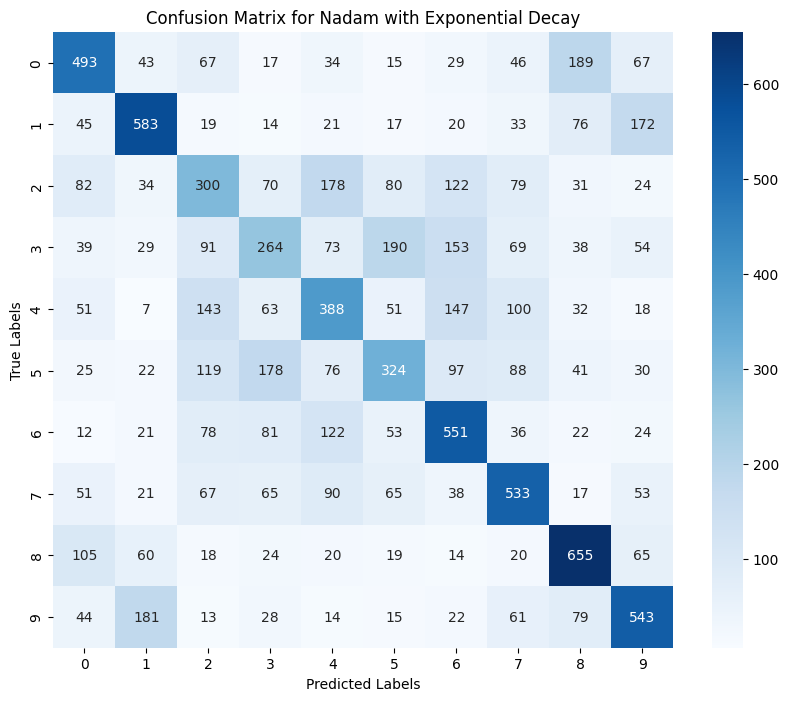

In [36]:
# Predict for confusion matrix
y_pred_exp = model.predict(x_test)
y_pred_classes_exp = np.argmax(y_pred_exp, axis=1)
y_true_exp = y_test.flatten()

# Compute confusion matrix
cm_exp = confusion_matrix(y_true_exp, y_pred_classes_exp)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_exp, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix for Nadam with Exponential Decay")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


**Training and Validation Accuracy/Loss Curves**

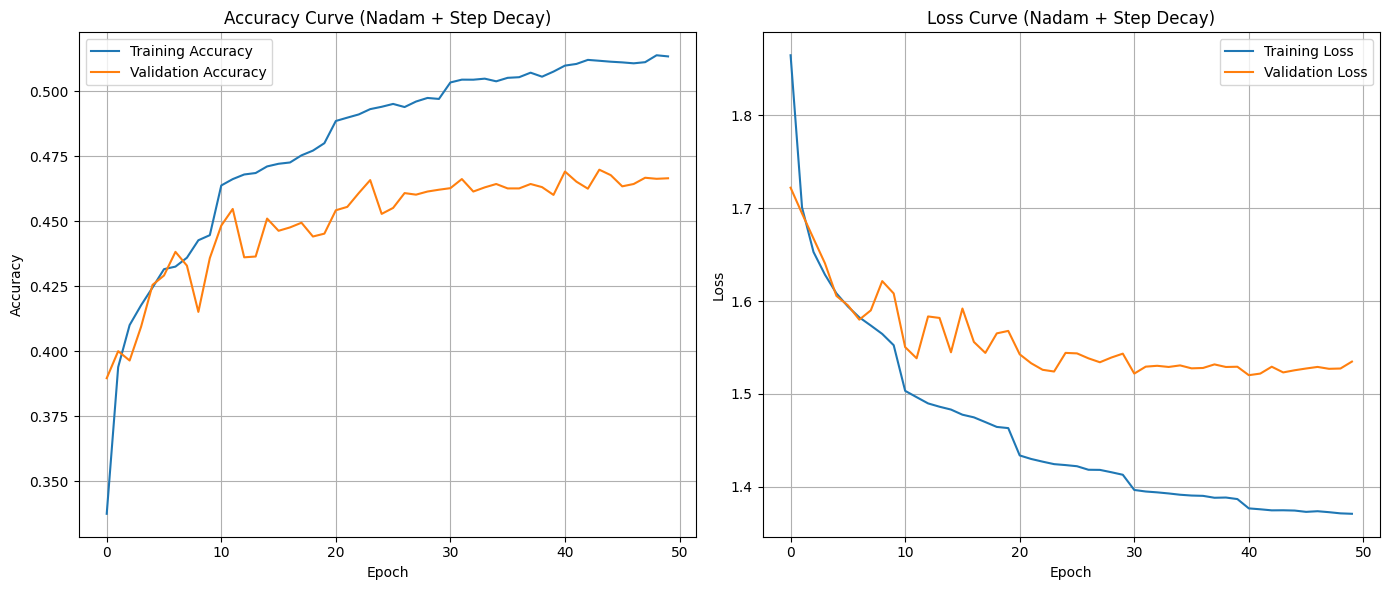

In [37]:
# Extract training and validation accuracy/loss from history
train_accuracy = history_nadam_step.history['accuracy']
val_accuracy = history_nadam_step.history['val_accuracy']
train_loss = history_nadam_step.history['loss']
val_loss = history_nadam_step.history['val_loss']

# Plot accuracy and loss curves
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy curve
ax[0].plot(train_accuracy, label='Training Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_title('Accuracy Curve (Nadam + Step Decay)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss curve
ax[1].plot(train_loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_title('Loss Curve (Nadam + Step Decay)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


**Learning Rate Schedule**

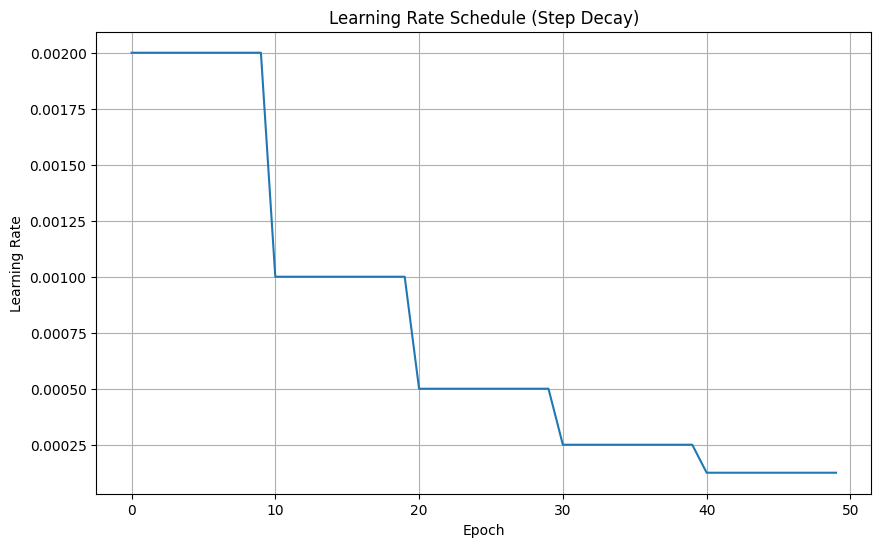

In [38]:
# Get learning rates at each epoch for the step decay
lr_schedule_values = [step_decay(epoch) for epoch in range(50)]

# Plot learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(range(50), lr_schedule_values, label='Learning Rate (Step Decay)')
plt.title('Learning Rate Schedule (Step Decay)')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()


**Class-Wise Accuracy**

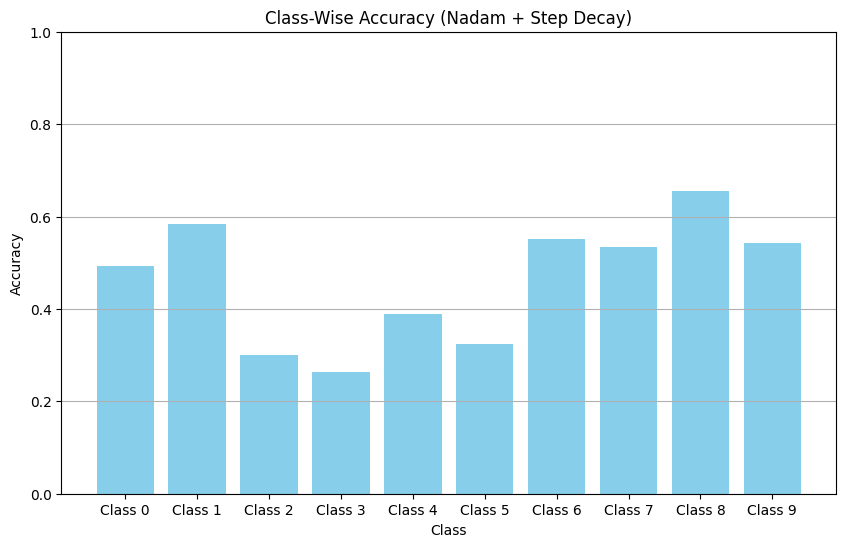

In [40]:
# Compute class-wise accuracy from confusion matrix
class_accuracy_nadam_step = np.diagonal(cm_exp) / np.sum(cm_exp, axis=1)

# Plot class-wise accuracy
plt.figure(figsize=(10, 6))
plt.bar(range(10), class_accuracy_nadam_step, color='skyblue')
plt.xticks(range(10), [f'Class {i}' for i in range(10)])
plt.ylim(0, 1)
plt.title('Class-Wise Accuracy (Nadam + Step Decay)')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.show()
